In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
jax.config.update('jax_default_device', 'cpu')
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')

# Testing Dynamic Factor Analysis (DFA)

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx

from jax import block_until_ready

from sppcax.models import BayesianDynamicFactorAnalysis as BDFA
from dynamax.linear_gaussian_ssm import parallel_lgssm_smoother

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Generate Synthetic Data

Generated z_true shape: (500, 2)
Generated y_obs shape: (500, 10)


<Axes: >

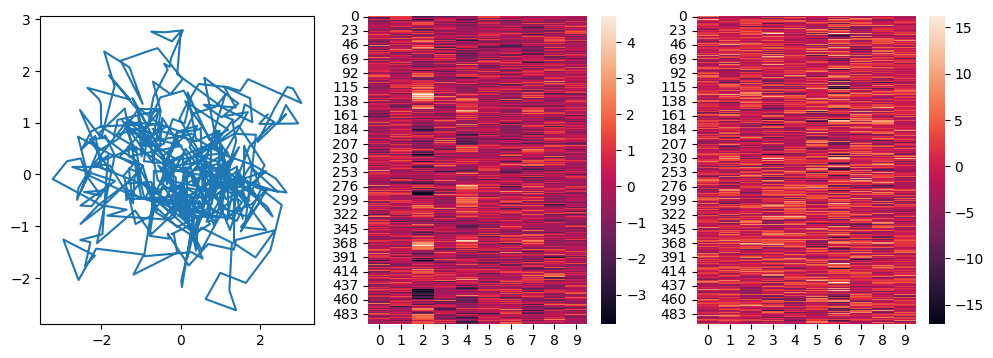

In [3]:
key = jr.PRNGKey(42)
n_components = 2  # Latent dimension (k)
n_features = 10   # Observation dimension (d)
n_timesteps = 500  # Time steps (T)

# True parameters
A_true = jnp.array([[0.9, 0.0], [0, 0.85]])

key, subkey = jr.split(key)
Q_true_diag = jr.uniform(subkey, (n_components,), minval=0.1, maxval=0.3)
Q_true = jnp.diag(Q_true_diag)

key, subkey1, subkey2 = jr.split(key, 3)
C_true = jr.normal(subkey1, (n_features, n_components)) * jr.bernoulli(subkey2, p=0.2, shape=(n_features, n_components))
sorted_idx = jnp.argsort(jnp.isclose(C_true, 0.0).sum(0))
C_true = C_true[:, sorted_idx]

key, subkey = jr.split(key)
R_true_diag = jr.uniform(subkey, (n_features,), minval=0.5, maxval=1.0)
R_true = jnp.diag(R_true_diag)

z0_true = jnp.zeros(n_components)
Sigma0_true = jnp.eye(n_components)

# Generate latent states (z) and observations (y)
z_true = jnp.zeros((n_timesteps, n_components))
y_obs = jnp.zeros((n_timesteps, n_features))

key, subkey1, subkey2 = jr.split(key, 3)
z_curr = jr.multivariate_normal(subkey1, z0_true, Sigma0_true)
z_true = z_true.at[0].set(z_curr)
y_obs = y_obs.at[0].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

for t in range(1, n_timesteps):
    key, subkey1, subkey2 = jr.split(key, 3)
    z_curr = jr.multivariate_normal(subkey1, A_true @ z_curr, Q_true)
    z_true = z_true.at[t].set(z_curr)
    y_obs = y_obs.at[t].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

n_input = 20
key, _key = jr.split(key)
U = jr.normal(_key, shape=(n_timesteps, n_input))

key, _key = jr.split(key)
B = jr.multivariate_normal(_key, jnp.zeros(n_features), R_true, shape=(n_input)).mT
y_obs_with_u = y_obs + U @ B.mT

print(f"Generated z_true shape: {z_true.shape}")
print(f"Generated y_obs shape: {y_obs.shape}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(z_true[:, 0], z_true[:, 1])
sns.heatmap(y_obs, ax=axes[1])
sns.heatmap(y_obs_with_u, ax=axes[2])

## 2. Initialize DFA Model

In [4]:
key, model_key = jr.split(key)
dfa_model = BDFA(n_components, n_features)

init_params, props = dfa_model.initialize(
    model_key,
    dynamics_weights=A_true,
    dynamics_covariance=Q_true,
    emission_weights=C_true,
    emission_covariance=R_true
)

## 3. Test latent state inference

5.15 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


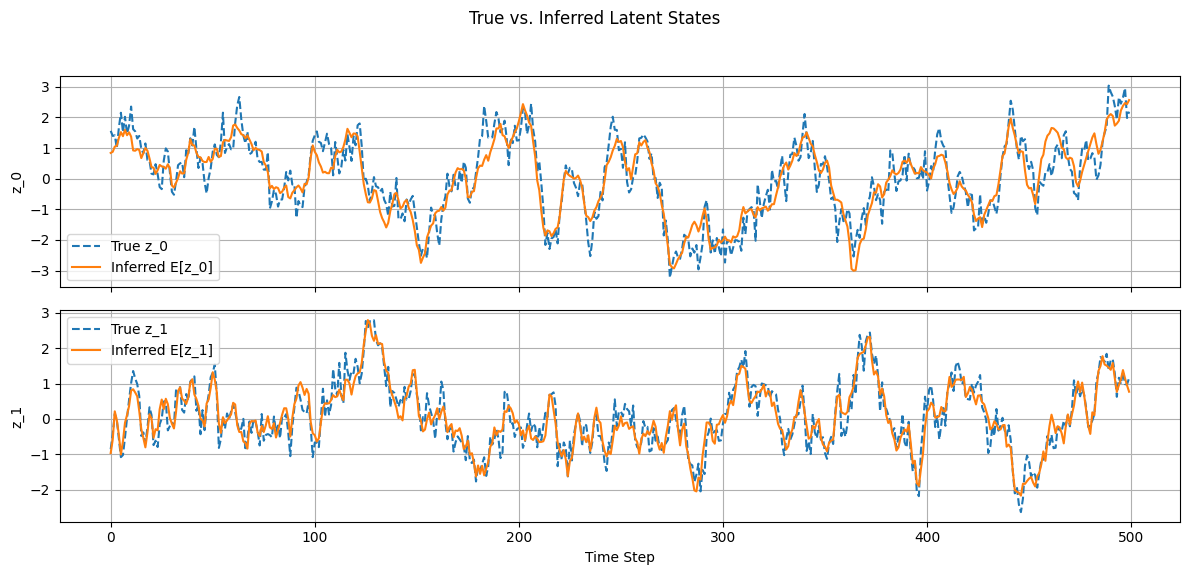

-6644.415581749049


In [5]:
# Run E-step
post = parallel_lgssm_smoother(init_params, y_obs)
Ez_smooth = post.smoothed_means

%timeit block_until_ready(eqx.filter_jit(parallel_lgssm_smoother)(init_params, y_obs))

# print(f"Inferred Ez_smooth shape: {Ez_smooth.shape}")

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    fig, axes = plt.subplots(n_components, 1, figsize=(12, 3 * n_components), sharex=True)
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
        axes[i].grid(True)
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())

## 4. Test VBM-step

In [6]:
from jax import vmap
from functools import partial
from dynamax.utils.utils import ensure_array_has_batch_dim

batch_stats, _ = vmap(partial(dfa_model.e_step, init_params))(y_obs[None], None)

dfa_model.m_step(init_params, props, batch_stats, None)

%timeit block_until_ready(eqx.filter_jit(dfa_model.m_step)(init_params, props, batch_stats, None))

535 μs ± 26.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# 5. Test the full VBEM algorithm

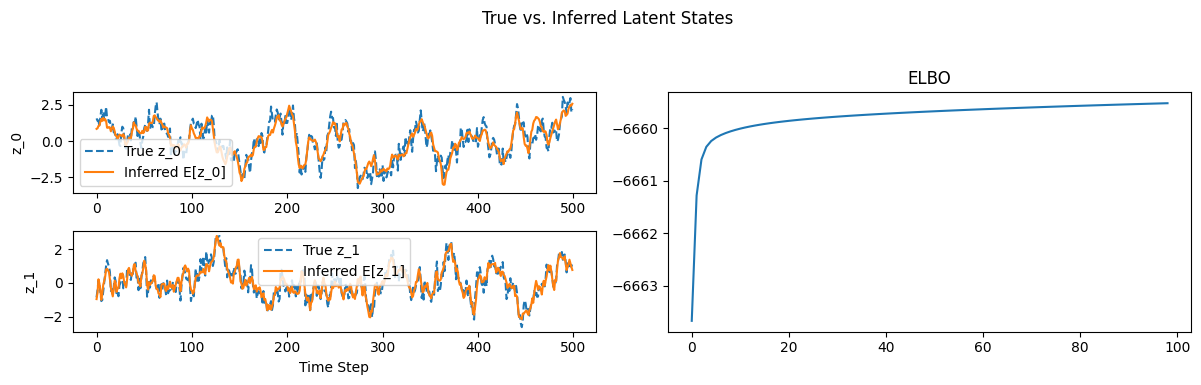

-6594.746788163008


In [7]:
key, _key = jr.split(key)
updated_params, elbos = dfa_model.fit_em(init_params, props, y_obs, _key, num_iters=100)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs)
Ez_smoot = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())

fig.tight_layout()

In [8]:
%timeit block_until_ready(dfa_model.fit_em(init_params, props, y_obs, _key, num_iters=100, verbose=False))

1.35 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 5. Test inputs driving obs

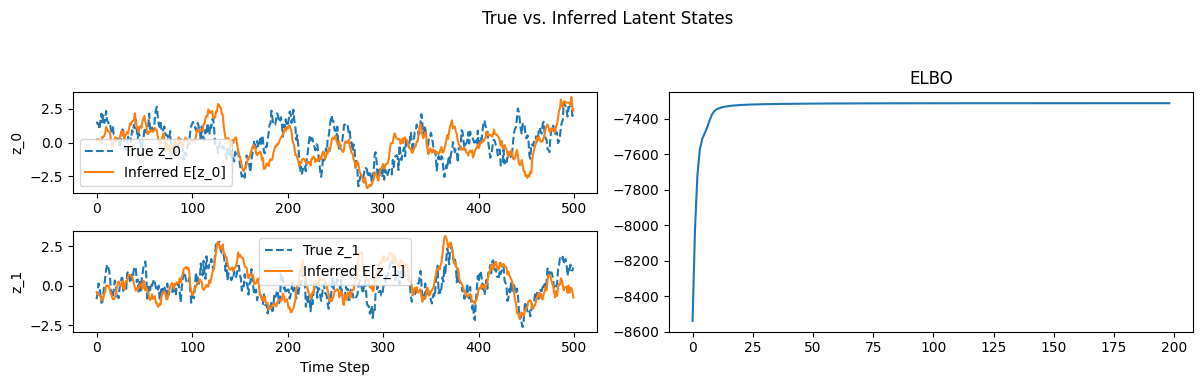

-6621.837184579315 -7313.559822333146


In [9]:
from sppcax.distributions import MultivariateNormalInverseGamma as MVNIG

emission_prior = MVNIG(
    jnp.zeros((n_features, n_components + n_input + 1)),
    precision=10*jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    emission_prior=emission_prior
)


key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key
)

key, _key = jr.split(key)
updated_params, elbos = dfa_model.fit_em(init_params, props, y_obs_with_u, _key, U=U, num_iters=200)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs_with_u, inputs=U)
Ez_smooth = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item(), elbos[-1])


fig.tight_layout()

# 6. Test inputs driving factors

In [10]:
key, _key = jr.split(key)
H_true = jr.multivariate_normal(_key, jnp.zeros(n_components), Q_true, shape=(n_input)).mT
# Generate latent states (z) and observations (y)
z_true = jnp.zeros((n_timesteps, n_components))
y_obs_if = jnp.zeros((n_timesteps, n_features))

key, subkey1, subkey2 = jr.split(key, 3)
z_curr = jr.multivariate_normal(subkey1, z0_true, Sigma0_true)
z_true = z_true.at[0].set(z_curr)
y_obs_if = y_obs_if.at[0].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

for t in range(1, n_timesteps):
    key, subkey1, subkey2 = jr.split(key, 3)
    z_curr = jr.multivariate_normal(subkey1, A_true @ z_curr + H_true @ U[t], Q_true)
    z_true = z_true.at[t].set(z_curr)
    y_obs_if = y_obs_if.at[t].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

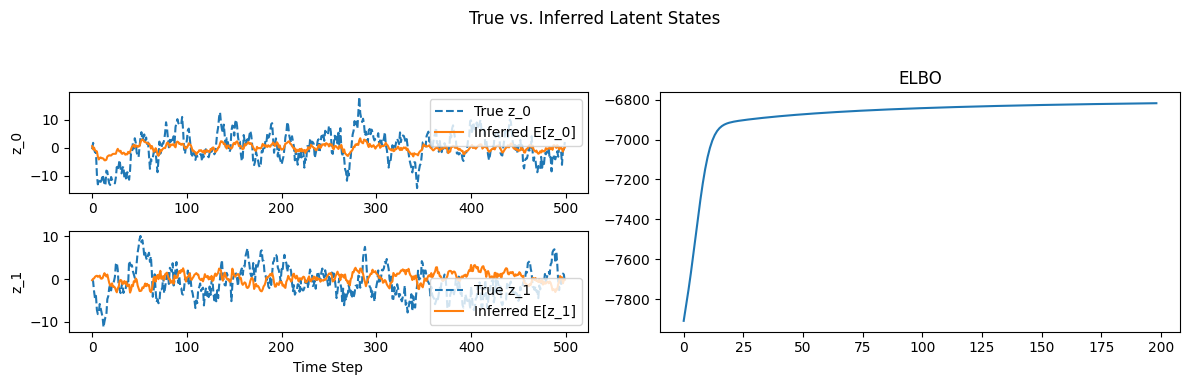

-6577.631913466867


In [11]:
dfa_model = BDFA(n_components, n_features, input_dim=n_input)
key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key
)

updated_params, elbos = dfa_model.fit_em(init_params, props, y_obs_if, _key, U=U, num_iters=200)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs_if, inputs=U)
Ez_smooth = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())
fig.tight_layout()

## Controling prior structure

-6577.631913466867 -7643.538616613194
-6577.631913466867 -7649.6434651444215


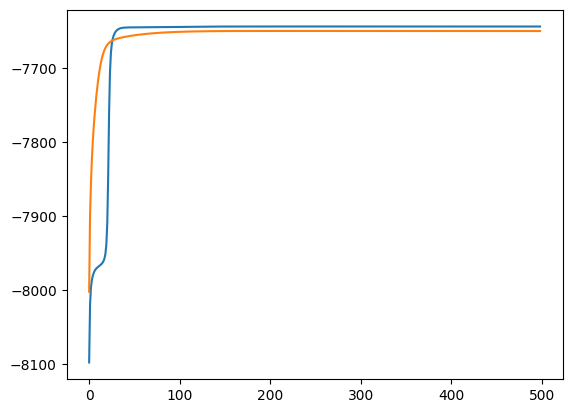

In [14]:
from dynamax.utils.distributions import NormalInverseWishart as NIW
from sppcax.distributions import MultivariateNormalInverseGamma as MVNIG

initial_prior = NIW(
    loc=jnp.zeros(n_components),
    mean_concentration=1.,
    df=n_components + 1.0,
    scale=jnp.eye(n_components)
)

loc = jnp.concatenate([A_true, H_true, jnp.zeros((n_components, 1))], -1)

dynamics_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=50.0,
    beta0=10.0,
    isotropic_noise=False,
    mask=None
)

loc = jnp.pad(C_true, [(0, 0), (0, n_input + 1)])
mask = jnp.pad(~jnp.isclose(C_true, 0.), [(0, 0), (0, n_input)], constant_values=False)
mask = jnp.pad(mask, [(0, 0), (0, 1)], constant_values=True)
emission_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
    mask=mask
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    initial_prior=initial_prior,
    dynamics_prior=dynamics_prior,
    emission_prior=emission_prior
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key
)

updated_params1, elbos = dfa_model.fit_em(
    init_params, props, y_obs_if, _key, U=U, num_iters=500, verbose=False)

plt.plot(elbos[1:])


# Run E-step
post1 = parallel_lgssm_smoother(updated_params1, y_obs_if, inputs=U)
print(post.marginal_loglik.item(), elbos[-1])

loc = jnp.concatenate([A_true, H_true, jnp.zeros((n_components, 1))], -1)

mask = jnp.pad(jnp.ones_like(A_true, dtype=jnp.bool), [(0, 0), (0, n_input + 1)])

dynamics_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=50.0,
    beta0=10.0,
    isotropic_noise=False,
    mask=mask
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    initial_prior=initial_prior,
    dynamics_prior=dynamics_prior,
    emission_prior=emission_prior
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key
)


updated_params4, elbos = dfa_model.fit_em(
    init_params, props, y_obs_if, _key, U=U, num_iters=500, verbose=False)

plt.plot(elbos[1:])

# Run E-step
post2 = parallel_lgssm_smoother(updated_params4, y_obs_if, inputs=U)
print(post.marginal_loglik.item(), elbos[-1])

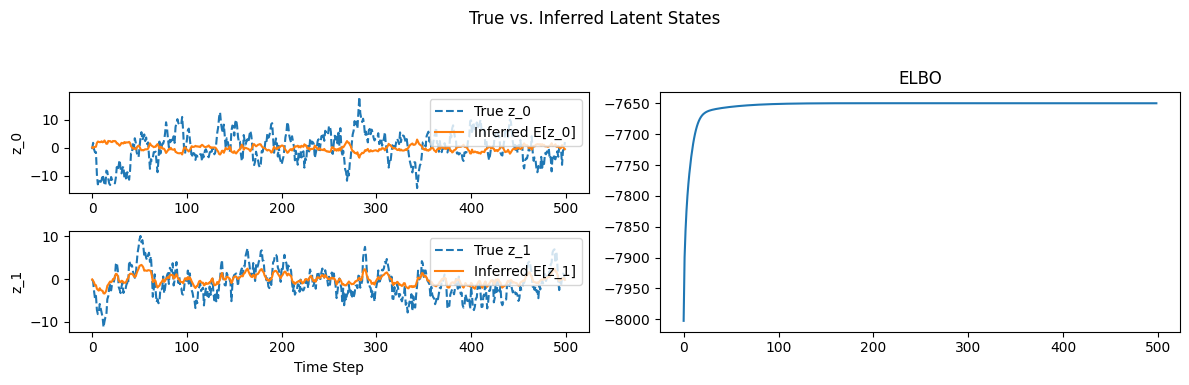

-6577.631913466867


In [15]:
Ez_smooth = post1.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, -Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())
fig.tight_layout()